# 4fold

If you wish to use GPU, change 'gpu' and 'use_gpu' in get_model accordingly.

if using faiss_als, make sure you have faiss installed. if annoy_als, annoy must be installed.

# Setup

In [5]:
import sys
sys.path.insert(0, '../src')
import preprocess
import utils
import random
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np
import implicit
import codecs
import json
from sklearn.model_selection import train_test_split, KFold

# Implicit

In [35]:
import argparse
import codecs
import logging
import time

import numpy
import pandas
from scipy.sparse import coo_matrix

from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                      NMSLibAlternatingLeastSquares)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

# maps command line model argument to class name
MODELS = {"als":  AlternatingLeastSquares,
          "nmslib_als": NMSLibAlternatingLeastSquares,
          "annoy_als": AnnoyAlternatingLeastSquares,
          "faiss_als": FaissAlternatingLeastSquares,
          "tfidf": TFIDFRecommender,
          "cosine": CosineRecommender,
          "bpr": BayesianPersonalizedRanking,
          "bm25": BM25Recommender}



# NOT USING GPU?? CHANGE CODE HERE
def get_model(model_name,k,lam):
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError("Unknown Model '%s'" % model_name)

    # some default params
    if model_name == "faiss_als":
        params = {'factors': k, 'dtype': numpy.float32, 'use_gpu': False, 
                  'gpu': False,  # keyerror -1
                  "calculate_training_loss": True, "regularization": lam, "iterations": 15}
    elif issubclass(model_class, AlternatingLeastSquares):
        params = {'factors': k, 'dtype': numpy.float32, 'use_gpu': False, 
                  #'gpu': True,  # keyerror -1
                  "calculate_training_loss": True, "regularization": lam, "iterations": 15}
    elif model_name == "bm25":
        params = {'K1': 100, 'B': 0.5}
    elif model_name == "bpr":
        params = {'factors': 63, 'use_gpu': True}
    else:
        params = {}

    return model_class(**params)


def read_data(filename):
    """ Reads in the AMINER dataset, and returns a tuple of a pandas dataframe
    and a sparse matrix of artist/user/playcount """
    # read in triples of user/artist/playcount from the input dataset
    # get a model based off the input params
    start = time.time()
    print("reading data from %s"% (filename))
    data = pandas.read_table(filename,
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'cites'],
                             na_filter=False)

    # map each artist and user to a unique numeric value
    data['user'] = data['user'].astype("category")
    data['ref'] = data['ref'].astype("category")

    # create a sparse matrix of all the users/plays
    cites = coo_matrix((data['cites'].astype(numpy.float32),
                       (data['ref'].cat.codes.copy(),
                        data['user'].cat.codes.copy())))

    print("read data file in {}".format( time.time() - start))
    return data, cites

def calculate_recommendations(k, lam, input_filename, recommend_filename, similar_filename, model_name="als"):
    """ Generates artist recommendations for each user in the dataset """
    # train the model based off input params
    df, cites = read_data(input_filename)

    # create a model from the input data
    model = get_model(model_name,k,lam) 

    # if we're training an ALS based model, weight input for last.fm
    # by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # lets weight these models by bm25weight.
        print("weighting matrix by bm25_weight")
        #cites = bm25_weight(cites, K1=100, B=0.8)

        # also disable building approximate recommend index
        model.approximate_similar_items = True

    # this is actually disturbingly expensive:
    cites = cites.tocsr()

    print("training model {}".format(model_name))
    start = time.time()
    model.fit(cites) 
    print("trained model '%s' in %0.2f"%( model_name, time.time() - start))

    # generate recommendations for each user and write out to a file
    LEN_RECOMMENDATION = 50
    artists = dict(enumerate(df['ref'].cat.categories))
    start = time.time()
    user_cites = cites.T.tocsr()
    with codecs.open(recommend_filename, "w", "utf8") as o:
        for userid, username in enumerate(df['user'].cat.categories):
            for artistid, score in model.recommend(userid, user_cites, N=LEN_RECOMMENDATION):
                try:
                    o.write("%s\t%s\t%s\n" % (username, artists[artistid], score))
                except:
                    print("artistid {} had an error".format(artistid))
                    print(artistid in artists)
                    print(artistid in df['user'].cat.categories)
    print("generated recommendations in %0.2f"%(  time.time() - start))
    #'''
    
    # write out similar papers being cited
    start = time.time()
    user_count = df.groupby('ref').size()
    to_generate = list(artists)#sorted(list(artists), key=lambda x: -user_count[x])
    
    # This might be useful for visualizing what we learned so far
    LEN_SIMILAR_LIST = 10
    print("returning similar papers depending on being cited by which")
    # write out as a TSV of artistid, otherartistid, score
    with codecs.open(similar_filename, "w", "utf8") as o:
        for artistid in to_generate:
            try:
                artist = artists[artistid]
            except:
                print("artistid {} had an error".format(artistid))
            for other, score in model.similar_items(artistid, LEN_SIMILAR_LIST):
                try:
                    o.write("%s\t%s\t%s\n" % (artist, artists[other], score))
                except:
                    print("other {} had an error".format(other))

    print("generated similar artists in %0.2f"%(time.time() - start))
def start(k, lam, inputfile, outputfile, similarfile, model='faiss_als'):

    #if recommend:
    calculate_recommendations(k, lam, inputfile, outputfile, similarfile, model_name=model)

# Run it on debug data

In [7]:
logging.getLogger("implicit").addHandler(logging.FileHandler('output.log', 'a'))

In [8]:
logging.getLogger("implicit").setLevel(logging.DEBUG)

In [9]:
!export OPENBLAS_NUM_THREADS=1
!export MKL_NUM_THREADS=1

In [36]:
lam = 0.1
k = 100
start(k, lam, '../dblp-ref/4fold/4fold_0_train.tsv', 
      "../als_4fold_rank_{}_lam_{}_recommend.tsv".format(k,lam), 
      "../als_4fold_rank_{}_lam_{}_similar.tsv".format(k,lam) , 
      model='als') # You can also choose 'faiss_als' which is best with gpu or 'annoy_als' with cpu

reading data from ../dblp-ref/4fold/4fold_0_train.tsv


DEBUG:implicit:Calculated transpose in 0.007s


read data file in 0.21310067176818848
weighting matrix by bm25_weight
training model als


DEBUG:implicit:initialize factors in 0.6622517108917236
DEBUG:implicit:finished iteration 0 in 8.462s
DEBUG:implicit:loss at iteration 0 is 3.146600574705915e-05
DEBUG:implicit:finished iteration 1 in 8.622s
DEBUG:implicit:loss at iteration 1 is 3.1055076790823015e-05
DEBUG:implicit:finished iteration 2 in 10.881s
DEBUG:implicit:loss at iteration 2 is 3.085051510995663e-05
DEBUG:implicit:finished iteration 3 in 10.614s
DEBUG:implicit:loss at iteration 3 is 3.077866975949774e-05
DEBUG:implicit:finished iteration 4 in 8.297s
DEBUG:implicit:loss at iteration 4 is 3.074931382660982e-05
DEBUG:implicit:finished iteration 5 in 7.724s
DEBUG:implicit:loss at iteration 5 is 3.0734643284068796e-05
DEBUG:implicit:finished iteration 6 in 7.537s
DEBUG:implicit:loss at iteration 6 is 3.072600443879217e-05
DEBUG:implicit:finished iteration 7 in 7.157s
DEBUG:implicit:loss at iteration 7 is 3.072029353265699e-05
DEBUG:implicit:finished iteration 8 in 6.888s
DEBUG:implicit:loss at iteration 8 is 3.071621

trained model 'als' in 122.51
generated recommendations in 754.47
returning similar papers depending on being cited by which


KeyboardInterrupt: 

In [37]:
data = pandas.read_table('../als_4fold_rank_100_lam_0.1_recommend.tsv',
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'cites'],
                             na_filter=False)

In [38]:
from collections import defaultdict
result = defaultdict(list)

for index, row in data.iterrows():
    result[row['user']].append(row['ref'])

In [20]:
len(result)

47018

In [39]:
trainDict = defaultdict(list)
trainDF = pandas.read_table('../dblp-ref/4fold/4fold_0_train.tsv',
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'cites'],
                             na_filter=False)
for index, row in trainDF.iterrows():
    trainDict[row['user']].append(row['ref'])
removeDict = defaultdict(list)
for key, values in result.items():
    for value in values:
        if value in trainDict[key]:
            removeDict[key].append(value)
for key, values in removeDict.items():
    for value in values:
        result[key].remove(value)

In [25]:
testDF = pandas.read_table('../dblp-ref/4fold/4fold_test.tsv',
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'cites'],
                             na_filter=False)
testDict = defaultdict(list)
for index, row in testDF.iterrows():
    testDict[row['user']].append(row['ref'])

In [26]:
validDF = pandas.read_table('../dblp-ref/4fold/4fold_0_val.tsv',
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'cites'],
                             na_filter=False)
validDict = defaultdict(list)
for index, row in validDF.iterrows():
    validDict[row['user']].append(row['ref'])

In [40]:
precisions_val = []
recalls_val = []
f1_val = []
klist = list(range(1,51))
for k in klist:
    topDict = dict()
    for key, value in result.items():
        if len(value) >= k:
            topDict[key]=value[:k]
        else:
            topDict[key]=value
    precisions, recalls = [], []
    for key, values in topDict.items():
        n_rel = len(validDict[key])
        if n_rel == 0:
            continue
        n_rec_k = len(values)
        n_rel_and_rec_k = 0
        for value in values:
            if value in validDict[key]:
                n_rel_and_rec_k += 1
        precisions.append( n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0 )
        recalls.append( n_rel_and_rec_k / n_rel if n_rel != 0 else 0 )
    precision=np.sum(precisions)/len(precisions)
    recall=np.sum(recalls)/len(recalls)
    precisions_val.append(precision) 
    recalls_val.append(recall) 
    f1_val.append(2*(precision*recall)/(precision+recall)) 

In [41]:
precisions_test = []
recalls_test = []
f1_test = []
for k in klist:
    topDict = dict()
    for key, value in result.items():
        if len(value) >= k:
            topDict[key]=value[:k]
        else:
            topDict[key]=value
    precisions, recalls = [], []
    for key, values in topDict.items():
        n_rel = len(testDict[key])
        if n_rel == 0:
            continue
        n_rec_k = len(values)
        n_rel_and_rec_k = 0
        for value in values:
            if value in testDict[key]:
                n_rel_and_rec_k += 1
        precisions.append( n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0 )
        recalls.append( n_rel_and_rec_k / n_rel if n_rel != 0 else 0 ) 
    precision=np.sum(precisions)/len(precisions)
    recall=np.sum(recalls)/len(recalls)
    precisions_test.append(precision)
    recalls_test.append(recall)
    f1_test.append(2*(precision*recall)/(precision+recall))

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

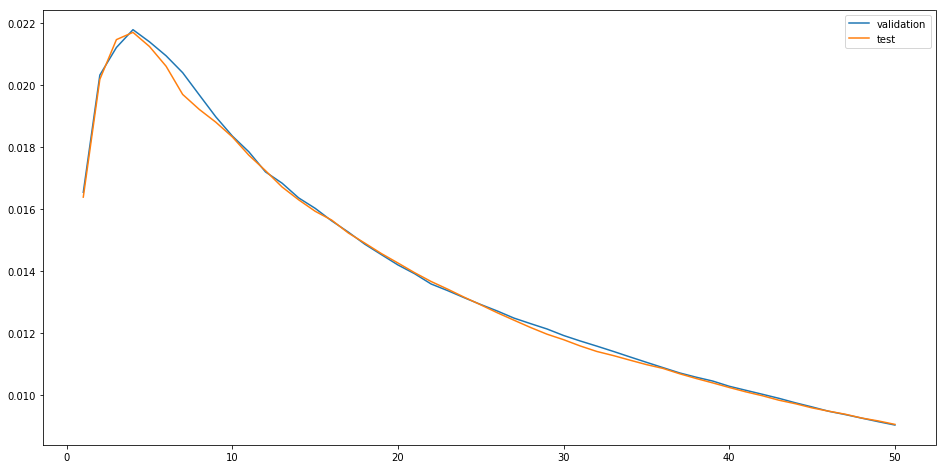

In [42]:
plt.plot(klist, f1_val, label="validation")
plt.plot(klist, f1_test, label="test")
plt.legend()
plt.show()

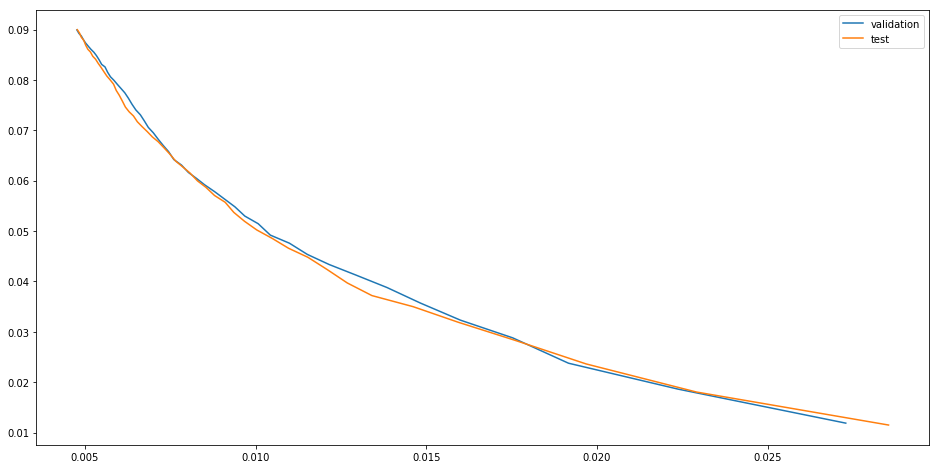

In [43]:
plt.plot(precisions_val, recalls_val, label="validation")
plt.plot(precisions_test, recalls_test, label="test")
plt.legend()
plt.show()

In [46]:
similar = pandas.read_table('../als_4fold_rank_100_lam_0.1_similar.tsv',
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'similarity'],
                             na_filter=False)

In [47]:
similar

,user,ref,similarity
0,30,67490,1.000000
1,30,471808,1.000000
2,30,2061459,1.000000
3,30,1804655,1.000000
4,30,1784470,1.000000
5,30,30,1.000000
6,30,448803,1.000000
7,30,1440230,1.000000
8,30,2386331,1.000000
9,30,988838,1.000000


In [52]:
def get_paper_names_given_numbering(datadir='../dblp-ref'):
    # When using surprise, it seems like we don't need this method.
    # This method assigns nonnegative integer numbers to each paper id,
    # and record it in a dictionary for efficient lookup.
    DBLP_LIST = [ datadir+'/dblp-ref-0.json',
        datadir+'/dblp-ref-1.json',
        datadir+'/dblp-ref-2.json',
        datadir+'/dblp-ref-3.json' ]
    
    name = dict()
    current_id = 0

    for data in DBLP_LIST:
        with open(data) as f:
            line = f.readline()
            while line:
                data = json.loads(line)
                name[current_id]   = data["title"]
                current_id += 1
                line = f.readline()

    return name

In [53]:
import json
name = get_paper_names_given_numbering()

In [57]:
i = 0
for index, row in similar.iterrows():
    print("paper 1: ", name[row['user']])
    print("paper 2: ", name[row['ref']])
    print("similarity: ", row['similarity'])
    print()
    i += 1
    if i >= 1000:
        break

paper 1:  Comparison of Fuzzy Edge Detectors Based on the Image Recognition Rate as Performance Index Calculated with Neural Networks
paper 2:  Modular Neural Networks and Fuzzy Sugeno Integral for Pattern Recognition: The Case of Human Face and Fingerprint
similarity:  1.0000001

paper 1:  Comparison of Fuzzy Edge Detectors Based on the Image Recognition Rate as Performance Index Calculated with Neural Networks
paper 2:  Modular neural networks optimization with hierarchical genetic algorithms with fuzzy response integration for pattern recognition
similarity:  1.0000001

paper 1:  Comparison of Fuzzy Edge Detectors Based on the Image Recognition Rate as Performance Index Calculated with Neural Networks
paper 2:  Minimum Classification Error Training for Choquet Integrals With Applications to Landmine Detection
similarity:  1.0000001

paper 1:  Comparison of Fuzzy Edge Detectors Based on the Image Recognition Rate as Performance Index Calculated with Neural Networks
paper 2:  A nonexc

similarity:  0.9999998999999999

paper 1:  A Highly Efficient RFID Distance Bounding Protocol without Real-Time PRF Evaluation
paper 2:  No cure for curiosity: linking physical and digital urban layers
similarity:  0.9999998

paper 1:  A Highly Efficient RFID Distance Bounding Protocol without Real-Time PRF Evaluation
paper 2:  A Highly Efficient RFID Distance Bounding Protocol without Real-Time PRF Evaluation
similarity:  0.9999998

paper 1:  A Highly Efficient RFID Distance Bounding Protocol without Real-Time PRF Evaluation
paper 2:  Detecting malicious web links and identifying their attack types
similarity:  0.9877154

paper 1:  A Highly Efficient RFID Distance Bounding Protocol without Real-Time PRF Evaluation
paper 2:  Intrusion detection using an ensemble of intelligent paradigms
similarity:  0.97383153

paper 1:  A Highly Efficient RFID Distance Bounding Protocol without Real-Time PRF Evaluation
paper 2:  Comparisons of machine learning techniques for detecting malicious webpag


paper 1:  First-Order Theorem Proving and Vampire
paper 2:  Mining the Archive of Formal Proofs
similarity:  0.999984

paper 1:  A MapReduce-Based Method for Learning Bayesian Network from Massive Data
paper 2:  A data-intensive approach for discovering user similarities in social behavioral interactions based on the bayesian network
similarity:  1.0000001

paper 1:  A MapReduce-Based Method for Learning Bayesian Network from Massive Data
paper 2:  Causal inference from financial factors: Continuous variable based local structure learning algorithm
similarity:  1.0000001

paper 1:  A MapReduce-Based Method for Learning Bayesian Network from Massive Data
paper 2:  Weighted ensemble learning of Bayesian network for gene regulatory networks
similarity:  1.0000001

paper 1:  A MapReduce-Based Method for Learning Bayesian Network from Massive Data
paper 2:  Towards Big Data Bayesian Network Learning - An Ensemble Learning Based Approach
similarity:  1.0000001

paper 1:  A MapReduce-Based M